**<center>AMEP Examples</center>**

<center>&copy; 2024 Lukas Hecht and the AMEP development team</center>

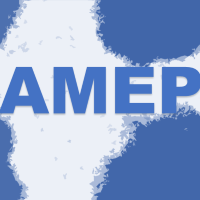

Welcome to the **A**ctive **M**atter **E**valuation **P**ackage (**AMEP**)! This Jupyter notebook serves as a starting point for everyone who uses **AMEP** for the first time. It provides two basic examples based on the data available at https://github.com/amepproject/amep/tree/main/examples/data:

[**Download zip**](https://download-directory.github.io/?url=https://github.com/amepproject/amep/tree/main/examples/data)

In the first example, we analyze simulation data from a LAMMPS simulation of active Brownian particles, in the second example of a continuum simulation of the Keller-Segel model for chemotaxis.

In [ ]:
# import required modules
import amep
import numpy as np

# Example 1: Particle-based data (active Brownian particles)

First, we load the simulation data and animate it:

In [ ]:
# load simulation data (returns a ParticleTrajectory object)
traj = amep.load.traj(
    './data/lammps',
    mode = 'lammps',
    dumps = 'dump*.txt',
    savedir = './data',
    trajfile = 'lammps.h5amep'
)

In [ ]:
# visualize the trajectories of the particles
traj.animate('./particles.mp4', xlabel=r'$x$', ylabel=r'$y$')

Next, we calculate three observables: the mean-square displacement (MSD), the orientational autocorrelation function (OACF), and the radial distribution function (RDF).

In [ ]:
# calculate the mean-square displacement of the particles
msd = amep.evaluate.MSD(traj)

In [ ]:
# calculate the orientational autocorrelation function
oacf = amep.evaluate.OACF(traj)

In [ ]:
# calculate the radial distribution function averaged over 10 frames
# (here we skip the first 80 % of the trajectory and do the calculation
# in parallel with 4 jobs)
rdf = amep.evaluate.RDF(
    traj, nav = 10, skip = 0.8, njobs = 4
)

Let us now save the results in a file:

In [ ]:
# save all analysis results in separate HDF5 files
msd.save('./msd.h5')
oacf.save('./oacf.h5')
rdf.save('./rdf.h5')

Alternatively, you can save all results in one HDF5 file using AMEP's evaluation database feature:

In [ ]:
# save all analysis results in one database file
msd.save('./results-db.h5', database = True)
oacf.save('./results-db.h5', database = True)
rdf.save('./results-db.h5', database = True)

The results can later be loaded using the `amep.load.evaluation` function for further processing.

Finally, we will exemplarily fit the orientational correlation function to extract the correlation time and plot all results using AMEP's Matplotlib wrapper. For that, we will first load the previously stored analysis results from the database file. Second, we will define the fit function and plot the results.

In [ ]:
# load all analysis data
results = amep.load.evaluation(
    './results-db.h5',
    database = True
)

In [ ]:
# check which data is available within the loaded file
results.keys()

In [ ]:
# fit the OACF results
def f(t, tau=1.0):
    return np.exp(-t/tau)

fit = amep.functions.Fit(f)
fit.fit(results.oacf.times, results.oacf.frames)

print(f"Fit result: tau = {fit.params[0]} +/- {fit.errors[0]}")

In [ ]:
# create a figure object
fig, axs = amep.plot.new(
    (6.5,2),
    ncols = 3,
    wspace = 0.1
)

# plot the MSD in a log-log plot
axs[0].plot(
    results.msd.times,
    results.msd.frames,
    label="data",
    marker=''
)
axs[0].set_xlabel("Time")
axs[0].set_ylabel("MSD")
axs[0].loglog()

# plot the OACF and the fit with logarithmic x axis
axs[1].plot(
    results.oacf.times,
    results.oacf.frames,
    label="data",
    marker=''
)
axs[1].plot(
    results.oacf.times,
    fit.generate(results.oacf.times),
    label="fit",
    marker='',
    color='orange',
    linestyle='--'
)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("OACF")
axs[1].semilogx()
axs[1].legend()

# plot the RDF
axs[2].plot(
    results.rdf.r,
    results.rdf.avg,
    marker=''
)
axs[2].set_xlabel("Distance")
axs[2].set_ylabel("RDF")

# save the figure as a pdf file
fig.savefig("particle-example.pdf")

# Example 2: Continuum data (Keller-Segel model)

First, we load the simulation data:

In [ ]:
# load simulation data (returns a FieldTrajectory object)
traj = amep.load.traj(
    './data/continuum',
    mode = 'field',
    dumps = 'field_*.txt',
    timestep = 0.01,
    savedir = './data',
    trajfile = 'continuum.h5amep'
)

Next, let us check which data is included within each frame of the trajectory file:

In [ ]:
traj[0].keys

Here, `'c'` denotes the chemical field and `'p'` the bacterial density. In the following, we will analyze the latter. Let us first animate it:

In [ ]:
# visualize the time evolution of the bacterial density p
traj.animate('./field.mp4', ftype='c', xlabel=r'$x$', ylabel=r'$y$', cbar_label=r'$c(x,y)$')

Next, we calculate and plot the local density distribution. Note that the following line is calculating the local density distribution for each frame within the trajectory. It is then averaging over all the results, i.e., it is performing a time average (`ldd.avg`). If the simulation is not in a steady state, one has be careful. Here, clearly not all frames are in the steady state. However, the results for each individual frame are still accessible (`ldd.frames`). We will use them here to plot the local density distribution for three different frames.

In [ ]:
# calculate the local density distribution
ldd = amep.evaluate.LDdist(
    traj, nav = traj.nframes, ftype = 'p'
)

In [ ]:
# create a new figure object
fig, axs = amep.plot.new()

# plot the results for three different frames
axs.plot(
    ldd.ld, ldd.frames[0,0],
    label = traj.times[0]
)
axs.plot(
    ldd.ld, ldd.frames[5,0],
    label = traj.times[5]
)

axs.plot(
    ldd.ld, ldd.frames[10,0],
    label = traj.times[10]
)

# add legends and labels
axs.legend(title = 'Time')
axs.set_xlabel(r'$\rho$')
axs.set_ylabel(r'$p(\rho)$')

# save the plot as a pdf file
fig.savefig('./continuum-example.pdf')

Finally, let us save the analysis results in an HDF5 file:

In [ ]:
ldd.save('./ldd.h5')